In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GPU-Accelerated 2-D Navier Stokes Simulation using NVIDIA Warp

## Overview

In this notebook, we will build a high-performance fluid solver entirely in Python using the Warp framework. Specifically, we will simulate 2-D turbulent flow in a box.

Through this implementation, you will learn:

* Writing SIMT (single instruction, multiple threads) kernels for Navier-Stokes operator and flow initialization
* Warp's tile-based programming primitives for efficient matrix operations
* CUDA graph capture for performance

By the end of this lab, we will have built a GPU-accelerated 2-D Navier-Stokes solver in a periodic box, while gaining experience in applying Warp's features to make GPU go brrr for a computational physics problem. 

---
## Setup

Before we begin implementing the 2-D N-S solver, let's ensure we have all the necessary packages installed.

In [2]:
# install Warp
%pip install warp-lang 

# install visualization package
%pip install matplotlib Pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Now let us import the necessary libraries and initialize Warp to check if GPU support is available:

In [3]:
import numpy as np
import warp as wp

if wp.get_cuda_device_count() > 0:
    print("GPU detected successfully")
else:
    print("No GPU detected!")

Warp 1.9.0 initialized:
   CUDA Toolkit 12.8, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX 5000 Ada Generation Laptop GPU" (16 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/snidhan/.cache/warp/1.9.0
GPU detected successfully


---
## Introduction

This seemingly simple 2-D N-S solver example combines multiple Warp features that can be leveraged to build industrial-grade solvers:
 - Accelerated Warp kernels for finite difference operators
 - Tile-based matrix operations for a more performant code
 - CUDA graph capture to speed-up multiple kernel calls to the same kernel

Before diving into the code, let's understand a bit of physics behind the Navier-Stokes equations in 2-D. 

---
## Background: Equations, boundary conditions, and initial conditions

### 1. Vorticity-stream function formulation

For 2-D incompressible flow, we define:
- **Vorticity**: $\omega = \partial v/\partial x - \partial u/\partial y$
- **Stream function**: $\psi$ such that $u = \partial\psi/\partial y$, $v = -\partial\psi/\partial x$

In the vorticity and stream function equation above, $u$ and $v$ are the two components of the velocity vector $\mathbf{u} = [u, v]$ in 2-D. This formulation automatically satisfies continuity and eliminates pressure from the Navier-Stokes equations.

### 2. Governing equation

In 2-D, the non-dimensional governing equations for incompressible flows can be written using the **vorticity-stream function transport equation** as

$$\underbrace{\frac{\partial \omega}{\partial t}}_{\text{unsteadiness}} + \underbrace{\frac{\partial \psi}{\partial y}\frac{\partial \omega}{\partial x} - \frac{\partial \psi}{\partial x}\frac{\partial \omega}{\partial y}}_{\text{advection}} = \underbrace{\frac{1}{Re}\left(\frac{\partial^2 \omega}{\partial x^2} + \frac{\partial^2 \omega}{\partial y^2}\right)}_{\text{diffusion}} \tag{1},$$

along with the relationship between stream function and vorticity, given by a Poisson equation. 

Starting from the definition of vorticity (in 2-D)
 
$$\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}.$$
 
Substituting the streamfunction relations $u = \frac{\partial \psi}{\partial y}$ and $v = -\frac{\partial \psi}{\partial x}$ gives
 
$$\omega = \frac{\partial}{\partial x}\left(-\frac{\partial \psi}{\partial x}\right) - \frac{\partial}{\partial y}\left(\frac{\partial \psi}{\partial y}\right),$$
 
$$\omega = -\frac{\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2}.$$
 
Rearranging gives the Poisson equation
 
$$\frac{\partial^2 \psi}{\partial x^2} + \frac{\partial^2 \psi}{\partial y^2} = -\omega \tag{2}.$$

When writing the solver, equations (1) and (2) will be solved at each timestep to evolve the flow.

### 3. Spectral Poisson solver

The Poisson equation in equation (2) can be discretized and solved using iterative methods like Jacobi and Gauss-Seidel methods. However, since we have a periodic domain, we can represent both $\omega$ and $\psi$ using Fourier series with sine and cosine basis functions. Specifically, we can write this as following
 
$$\omega(x,y) = \sum_{m,n} \hat{\omega}_{m,n} e^{i(k_x x + k_y y)},$$
 
$$\psi(x,y) = \sum_{m,n} \hat{\psi}_{m,n} e^{i(k_x x + k_y y)},$$
 
where $\hat{\omega}_{m,n}$ and $\hat{\psi}_{m,n}$ are what we call the Fourier coefficients, and $k_x = \frac{2\pi m}{L_x}$ and $k_y = \frac{2\pi n}{L_y}$ are the wavenumbers of the sine and cosine basis functions. Now, if we substitute these Fourier representations back into equation (2), we can compute the derivatives as

$$\frac{\partial^2 \psi}{\partial x^2} = \sum_{m,n} -k_x^2 \hat{\psi}_{m,n} e^{i(k_x x + k_y y)},$$
 
$$\frac{\partial^2 \psi}{\partial y^2} = \sum_{m,n} -k_y^2 \hat{\psi}_{m,n} e^{i(k_x x + k_y y)}.$$
 
Substituting these into the Poisson equation, i.e., equation (2) above will result in
 
$$\sum_{m,n} -(k_x^2 + k_y^2) \hat{\psi}_{m,n} e^{i(k_x x + k_y y)} = -\sum_{m,n} \hat{\omega}_{m,n} e^{i(k_x x + k_y y)}.$$
 
Since this must hold for each pair of $[k_x, k_y]$ independently, **the Poisson equation reduces to a simple algebraic equation in Fourier space**. Note that **Fourier space** refers to the spectral domain where we work directly with the Fourier coefficients $\hat{\omega}_{m,n}$ and $\hat{\psi}_{m,n}$ along with their corresponding wavenumbers $k_x$ and $k_y$. After solving in Fourier space, we recover the physical fields $\omega$ and $\psi$ using the inverse Fourier transform. The wavenumbers are defined as $k_x = \frac{2\pi m}{L_x}, \quad k_y = \frac{2\pi n}{L_y}$, where $m$ and $n$ are the Fourier mode indices ranging from $[-N/2, N/2 -1]$ (with $N$ being the total number of grid points). 


### 4. Time integration 
Runge-Kutta methods advance the solution by taking multiple intermediate "substeps" within each timestep, achieving better accuracy than a single forward step. In this example, we use a **strong-stability preserving (SSP) third-order** **explicit** Runge-Kutta method.

- **Third-order**: The numerical error scales as $\mathcal{O}(\Delta t)^3$. Halving the timestep reduces error by $\sim 8\times$.

- **SSP**: Schemes designed specifically to prevent spurious oscillations for hyperbolic PDEs.

- **Explicit**: Each new timestep is computed directly from the previous one (no equation systems to solve), making it fast and GPU-friendly.

SSP RK3 scheme takes the following form below, where $\omega^{(n)}$ and $\omega^{(n+1)}$ are the vorticity field at the beginning and the end of a timestep. $\omega^{(1)}$ and $\omega^{(2)}$ are the intermediate vorticity fields.

$$\omega^{(1)} = \omega^{(n)} + \Delta t \mathcal{L}(\omega^{(n)}),$$
 
$$\omega^{(2)} = \frac{3}{4}\omega^{(n)} + \frac{1}{4}\omega^{(1)} + \frac{1}{4}\Delta t \mathcal{L}(\omega^{(1)}),$$ 

$$\omega^{(n+1)} = \frac{1}{3}\omega^{(n)} + \frac{2}{3}\omega^{(2)} + \frac{2}{3}\Delta t \mathcal{L}(\omega^{(2)}). \tag{4}$$

Here $\mathcal{L}(\omega)$ encapsulates the finite-difference forms of both advection and diffusion terms in equation (1). 

**NOTE**: Other time-stepping schemes can be implemented with minimal changes to the code, but we use the scheme above as a demonstration example.

### 5. Initial condition: 2-D decaying turbulence

In this problem, we solve the governing equations on a square domain of size $2\pi \times 2\pi$. Recall that the wavenumbers are defined as $k_x = 2 \pi m / L_x$ and $k_y = 2 \pi n / L_y$. By choosing $L_x = L_y = 2\pi$, the wavenumbers $k_x$ and $k_y$ become integers (specifically, $k_x = m$ and $k_y = n$), which simplifies some of the FFT-based operations. This choice of domain size is a common convention in spectral solver literature for this reason.

The initial condition is generated using the energy spectrum from San & Staples CNF (2012)

$$E(k) = \frac{a_s}{2 k_p}\left(\frac{k}{k_p}\right)^{2s+1} \exp\left[-\left(s + \frac{1}{2}\right)\left(\frac{k}{k_p}\right)^2\right] \tag{5},$$

where
- $k = |\mathbf{k}| = \sqrt{k_x^2 + k_y^2}$,
- $k_p = 12 (wavenumber at which $E(k)$ peaks), 
- $s = 3$ (shape parameter of the spectrum),
- $a_s = (2s+1)^{s+1}/(2^s s!)$.

The magnitude of Fourier coefficients related to the initial energy spectrum is given by 

$$|\hat{\omega}(\mathbf{k})| = \sqrt{\frac{k}{\pi}E(k)},$$

which is then randomized with a phase function $\zeta(\mathbf{k})$ so that $\hat{\omega}(k_x, k_y) = \hat{\omega}(\mathbf{k})$ becomes 

$$\hat{\omega}(\mathbf{k}) = \sqrt{\frac{k}{\pi}E(k)} \, e^{i\zeta(\mathbf{k})}. \tag{6}$$
 
The phase function $\zeta(\mathbf{k})$ is constructed with specific symmetry constraints to ensure that the vorticity field $\omega(x,y)$ is real-valued in the physical space. The details of how $\zeta(\mathbf{k})$ is formulated is provided in **Appendix A**.

**NOTE**: Other similar flow initialization can be implemented, but we use the decaying turbulence above as a demonstration example. We encourage you to play with different flow initializations.

---
## Building blocks of the solver

$$
\boxed{\;\;
\begin{array}{c}
\large\textbf{Solver Pipeline} \\[14pt]
\hat{\omega} \;\xrightarrow{\;\text{IFFT}\;}\; \omega(t) \;\xrightarrow{\quad}\;
\underbrace{\text{Discretize} \;\to\; \text{1 RK substep} \;\to\; \text{Poisson solve}}_{\times\, 3 \text{\ times for a RK3 scheme}} 
\;\xrightarrow{\quad}\; \omega(t+\Delta t) \\[6pt]
\uparrow \hspace{24em} \downarrow \\[-2pt]
\xleftarrow{\hspace{8em} \text{For next timestep} \hspace{10em}}
\end{array}
\;\;}
$$

There are four main building blocks of the solver that we would tackle in a sequential manner.

- Initialize $\omega$ -- Generate $\hat{\omega}$ in Fourier space using the energy spectrum specified above and inverse FFT to physical space.
- Discretize the advection and diffusion terms to obtain the RHS $\mathcal{L}(\omega)$ of $\frac{\partial \omega}{\partial t} = \mathcal{L}(\omega)$.
- RK substep to advance $\omega(t)$ to $\omega(t+\Delta t)$ using Runge-Kutta timestepping.
- Solve Poisson equation $\hat{\psi}_{m,n} = \hat{\omega}_{m,n}/(k_x^2 + k_y^2)$ and inverse FFT to $\psi$.  

---
## Simulation parameters

In [4]:
# grid resolution
N_GRID = 512
# box size
LEN = 2 * np.pi
# delta t for timestepping
DT = 0.001
# Reynolds number
RE = 1000.0
# define SSP-RK3 coefficients used for timestepping
RK3_COEFFS = [
    [1.0, 0.0, 1.0],
    [3.0 / 4.0, 1.0 / 4.0, 1.0 / 4.0],
    [1.0 / 3.0, 2.0 / 3.0, 2.0 / 3.0],
]
# h = l/N (size of a computational cell)
H = LEN / N_GRID

# parameters for Warp's tiled-FFT functionality
TILE_M = 1
TILE_N = N_GRID
TILE_TRANSPOSE_DIM = 16
BLOCK_DIM = TILE_N // 2

---
## Building block 1: Flow initialization in Warp

Recall from equation (6) in the Background section that the initial vorticity field $\hat{\omega}(\mathbf{k})$ in Fourier space is given by

$$\hat{\omega}(\mathbf{k}) = \underbrace{\sqrt{\frac{k}{\pi}E(k)}}_{\text{amplitude}} \cdot \underbrace{e^{i\zeta(\mathbf{k})}}_{\text{phase}} = \underbrace{\sqrt{\frac{k}{\pi}E(k)}}_{\text{amplitude}} \cdot \left(\cos\zeta(\mathbf{k}) + i\sin\zeta(\mathbf{k})\right),$$

which gives us the real and imaginary parts
 
$$\text{Re}(\hat{\omega}) = \sqrt{\frac{k}{\pi}E(k)} \cos\zeta(\mathbf{k}), \quad \text{Im}(\hat{\omega}) = \sqrt{\frac{k}{\pi}E(k)} \sin\zeta(\mathbf{k}).$$

$E(k)$ is the energy spectrum (equation 5) and $\zeta(\mathbf{k}) = \xi(\mathbf{k}) + \eta(\mathbf{k})$ is the phase function with symmetry constraints ensuring a real-valued physical field.

**What do we need to implement?**

To initialize the flow, we need:

1. A kernel to populate $\hat{\omega}(\mathbf{k})$ on the entire 2-D grid using equation (6).

2. Two helper functions for that kernel (and equation 6):

     a. A function to compute the **energy spectrum** $E(k)$ at each wavenumber magnitude.

     b. A function to compute the **phase** $\zeta(\mathbf{k})$ with proper symmetry across quadrants.
  
The helper functions will be `@wp.func` device functions (callable from kernels), and the initialization will be a `@wp.kernel` that launches one thread per grid point.

**Note on Warp math utilities:** Warp provides built-in trigonometric functions like `wp.cos()` and `wp.sin()` for use in kernels. For complex number arithmetic, Warp uses `wp.vec2f` and `wp.vec2d` as data types for 32-bit and 64-bit precision, respectively. For example, complex numbers can represented as `wp.vec2f(real_part, imaginary_part)`, where the first component is the real part of type `wp.float32` and the second component is the imaginary part of type `wp.float32`.

**Exercise: Assuming the helper functions are correct, complete the kernel `decaying_turbulence_initializer(...)` by computing the amplitude using `energy_spectrum(...)`, the phase using `phase_randomizer(...)`, and combining them to form the complex valued `omega_hat_init[i, j]`.**

In [5]:
@wp.func
def factorial(n: wp.int32) -> wp.int32:
    """Compute factorial.

    Args:
        n: Input integer for which we want factorial.

    Returns:
        Factorial of input n.
    """
    result = wp.int32(1)
    for i in range(2, n + 1):
        result *= i
    return result


@wp.func
def energy_spectrum(k: wp.float32, s: wp.int32, kp: wp.float32) -> wp.float32:
    """Compute energy at wavenumber magnitude k.

    Follows San and Staples 2012 Computers and Fluids (page 49).
    https://www.sciencedirect.com/science/article/abs/pii/S0045793012001363.

    Args:
        k: Input wavenumber magnitude.
        s: Shape parameter of spectrum.
        kp: Wavenumber magnitude at which maximum of energy spectrum lies.

    Returns:
        Energy contained at wavenumber magnitude k.
    """
    s_factorial = wp.float32(factorial(s))
    s_float32 = wp.float32(s)
    a_s = (2.0 * s_float32 + 1.0) ** (s_float32 + 1.0) / (2.0**s_float32 * s_factorial)
    energy_k = (
        a_s
        / (2.0 * kp)
        * (k / kp) ** (2.0 * s_float32 + 1.0)
        * wp.exp(-(s_float32 + 0.5) * (k / kp) ** 2.0)
    )
    return energy_k


@wp.func
def phase_randomizer(
    n: int,
    zeta: wp.array2d(dtype=wp.float32),
    eta: wp.array2d(dtype=wp.float32),
    i: int,
    j: int,
) -> wp.float32:
    """Calculate value of the random phase at index (i, j).

    Follows San and Staples 2012 to return phase value in any quadrant based on
    the values of eta and zeta in the first quadrant.

    Args:
        n: Size of the simulation domain.
        zeta: First phase function.
        eta: Second phase function
        i: rowwise index on the 2-D simulation domain.
        j: columnwise index on the 2-D simulation domain

    Returns:
        Value of the random phase in any quadrant.
    """
    n_half = n // 2

    # first quadrant
    if i < n_half and j < n_half:
        return zeta[i, j] + eta[i, j]
    # second quadrant
    if i >= n_half and j < n_half:
        return -zeta[n - i, j] + eta[n - i, j]
    # third quadrant
    if i >= n_half and j >= n_half:
        return -zeta[n - i, n - j] - eta[n - i, n - j]
    # fourth quadrant
    return zeta[i, n - j] - eta[i, n - j]

@wp.kernel
def decaying_turbulence_initializer(
    n: int,
    kp: wp.float32,
    s: wp.int32,
    k_mag: wp.array2d(dtype=wp.float32),
    zeta: wp.array2d(dtype=wp.float32),
    eta: wp.array2d(dtype=wp.float32),
    omega_hat_init: wp.array2d(dtype=wp.vec2f), # In Warp, wp.vec2f/wp.vec2d are used to handle complex numbers
):
    """Initialize the vorticity field in Fourier space for decaying turbulence.

    Args:
        n: Size of the simulation domain.
        kp: Wavenumber magnitude at which maximum of energy spectrum lies.
        s: Shape parameter of the energy spectrum.
        k_mag: Wavenumber magnitude on the 2-D grid.
        zeta: First phase function for phase randomization.
        eta: Second phase function for phase randomization.
        omega_hat_init: Output vorticity field in Fourier space.
    """
    i, j = wp.tid()

    amplitude = wp.sqrt((k_mag[i, j] / wp.pi) * energy_spectrum(k_mag[i, j], s, kp)) # MISSING
    phase = phase_randomizer(n, zeta, eta, i, j) # MISSING
    omega_hat_init[i, j] = wp.vec2f(amplitude*wp.cos(phase), amplitude*wp.sin(phase)) # MISSING

---
## Building blocks 2 and 3: Discretization of advection and viscous diffusion terms for RHS as well as Runge-Kutta timestepping

Recall the vorticity transport equation (1) from the Background section given as

$$\frac{\partial \omega}{\partial t} + \underbrace{\frac{\partial \psi}{\partial y}\frac{\partial \omega}{\partial x} - \frac{\partial \psi}{\partial x}\frac{\partial \omega}{\partial y}}_{\text{advection}} = \underbrace{\frac{1}{Re}\left(\frac{\partial^2 \omega}{\partial x^2} + \frac{\partial^2 \omega}{\partial y^2}\right)}_{\text{diffusion}}.$$

We discretize the **advection** and **diffusion** terms on a **uniform grid** using **central finite difference schemes**.
### Advection term

Using central differences for first derivatives with grid spacing $h$,

$$\frac{\partial \omega}{\partial x}\bigg|_{i,j} \approx \frac{\omega_{i+1,j} - \omega_{i-1,j}}{2h}, \quad \frac{\partial \omega}{\partial y}\bigg|_{i,j} \approx \frac{\omega_{i,j+1} - \omega_{i,j-1}}{2h}, \quad \frac{\partial \psi}{\partial x}\bigg|_{i,j} \approx \frac{\psi_{i+1,j} - \psi_{i-1,j}}{2h}, \quad \frac{\partial \psi}{\partial y}\bigg|_{i,j} \approx \frac{\psi_{i,j+1} - \psi_{i,j-1}}{2h}.$$

The advection term becomes

$$\text{Advection}_{i,j} = \underbrace{\frac{\omega_{i+1,j} - \omega_{i-1,j}}{2h} \cdot \frac{\psi_{i,j+1} - \psi_{i,j-1}}{2h}}_{\texttt{term\_1}} - \underbrace{\frac{\omega_{i,j+1} - \omega_{i,j-1}}{2h} \cdot \frac{\psi_{i+1,j} - \psi_{i-1,j}}{2h}}_{\texttt{term\_2}}.$$

### Diffusion (or Laplacian) term

Using the standard 5-point stencil for the Laplacian, the diffusion term becomes

$$\text{Diffusion}_{i,j}  = \nabla^2 \omega\bigg|_{i,j} = \frac{\partial^2 \omega}{\partial x^2}\bigg|_{i,j} + \frac{\partial^2 \omega}{\partial y^2}\bigg|_{i,j} \approx \frac{\omega_{i+1,j} - 2\omega_{i,j} + \omega_{i-1,j}}{h^2} + \frac{\omega_{i,j+1} - 2\omega_{i,j} + \omega_{i,j-1}}{h^2} = \frac{\omega_{i+1,j} + \omega_{i-1,j} + \omega_{i,j+1} + \omega_{i,j-1} - 4\omega_{i,j}}{h^2}.$$

### Runge-Kutta timestepping

Recall the SSP-RK3 scheme from equation (4). Each sub-step has the general form

$$\omega^{(\text{new})} = c_0 \cdot \omega^{(n)} + c_1 \cdot \omega^{(\text{old})} + c_2 \cdot \Delta t \cdot \mathcal{L}(\omega^{(\text{old})}),$$

where $\mathcal{L}(\omega) = \frac{1}{Re}\text{Diffusion} - \text{Advection}$ is the RHS we just discretized above. $\omega^{(n)}$ is the vorticity field on at the beginning of the older timestep $t$. $\omega^{\text{old}}$ and $\omega^{\text{new}}$ are the vorticity field at the beginning and the end of a RK substep, respectively. 

**NOTE**: At the first and last RK substep specifically, $\omega^{\text{(new)}}$ and $\omega^{\text{(old)}}$ are equal to $\omega(t+1)$ and $\omega(t)$, respectively. For intermediate RK substeps, this does not necessarily hold true.

In a Warp kernel, all of these operations would translate to:
1. Compute `rhs = (1/Re) * diffusion(...) - advection(...)`.
2. Update `omega_new = coeff0 * omega_n + coeff1 * omega_old + coeff2 * dt * rhs`, where `omega_n` is the vorticity field at the very beginning on the RK timestepping. By passing different coefficients, each time the kernel is called, the same kernel can handle all three RK sub-steps.

**What do we need to implement?**

Two `@wp.func` helper functions:
1. `viscous_advection_rk3_kernel(...)` - Warp kernel that calls two Warp functions `advection(...)` and `diffusion(...)` to calculate the advection and diffusion terms, and then performs one RK update on the entire 2-D grid.
2. `advection(...)` - Warp function that computes the advection term at a grid point given the flow information on the neighboring left, right, top, and bottom neighbors.
3. `diffusion(...)` - Warp function computes the Laplacian at a grid point given the flow information on the left, right, top and bottom neighbors.

**Exercise: Fill in the MISSING parts in `advection(...)`, `diffusion(...)`, and `viscous_advection_rk3_kernel(...)` using the finite difference formulas described above and the RK update equation.**


In [6]:
@wp.func
def cyclic_index(idx: wp.int32, n: wp.int32) -> wp.int32:
    """Map any index to [0, n-1] for periodic boundary conditions.

    Args:
        idx: Input index that may be outside the valid range.
        n: Grid size defining the periodic domain.

    Returns:
        Index wrapped to the range [0, n-1].
    """
    ret_idx = idx % n
    if ret_idx < 0:
        ret_idx += n
    return ret_idx
    
@wp.func
def advection(
    omega_left: wp.float32,
    omega_right: wp.float32,
    omega_top: wp.float32,
    omega_down: wp.float32,
    psi_left: wp.float32,
    psi_right: wp.float32,
    psi_top: wp.float32,
    psi_down: wp.float32,
    h: wp.float32,
) -> wp.float32:
    """Calculate the advection term using central finite difference.

    Args:
        omega_left: Vorticity at (i-1, j).
        omega_right: Vorticity at (i+1, j).
        omega_top: Vorticity at (i, j+1).
        omega_down: Vorticity at (i, j-1).
        psi_left: Stream function at (i-1, j).
        psi_right: Stream function at (i+1, j).
        psi_top: Stream function at (i, j+1).
        psi_down: Stream function at (i, j-1).
        h: Grid spacing.

    Returns:
        Advection term value at grid point (i, j).
    """
    inv_2h = 1.0 / (2.0 * h)
    term_1 = ((omega_right - omega_left) * inv_2h) * ((psi_top - psi_down) * inv_2h) # MISSING
    term_2 = ((omega_top - omega_down) * inv_2h) * ((psi_right - psi_left) * inv_2h) # MISSING
    return term_1 - term_2


@wp.func
def diffusion(
    omega_left: wp.float32,
    omega_right: wp.float32,
    omega_center: wp.float32,
    omega_down: wp.float32,
    omega_top: wp.float32,
    h: wp.float32,
) -> wp.float32:
    """Calculate the Laplacian for viscous diffusion using central difference.

    Args:
        omega_left: Vorticity at (i-1, j).
        omega_right: Vorticity at (i+1, j).
        omega_center: Vorticity at (i, j).
        omega_down: Vorticity at (i, j-1).
        omega_top: Vorticity at (i, j+1).
        h: Grid spacing.

    Returns:
        Laplacian of vorticity at grid point (i, j).
    """
    inv_h2 = 1.0 / (h * h)
    # combine both the diffusion terms in the x and y direction together
    laplacian = (omega_left + omega_right + omega_top + omega_down - 4.0*omega_center) * inv_h2 # MISSING
    return laplacian

    
@wp.kernel
def viscous_advection_rk3_kernel(
    n: int,
    h: float,
    re: float,
    dt: float,
    coeff0: float,
    coeff1: float,
    coeff2: float,
    omega_0: wp.array2d(dtype=float),
    omega_1: wp.array2d(dtype=float),
    psi: wp.array2d(dtype=float),
    rhs: wp.array2d(dtype=float),
):
    """Perform a single substep of SSP-RK3.

    Args:
        n: Grid size.
        h: Grid spacing.
        re: Reynolds number.
        dt: Timestep size.
        coeff0: SSP-RK3 coefficient for omega_0.
        coeff1: SSP-RK3 coefficient for omega_1.
        coeff2: SSP-RK3 coefficient for RHS.
        omega_0: Vorticity field at the beginning of the timestep.
        omega_1: Vorticity field at the end of the RK step.
        psi: Stream function field.
        rhs: Temporarily stores diffusion + advection terms.
    """
    i, j = wp.tid()

    # obtain the neighboring indices for the [i, j]th cell in a periodic square box
    left_idx = cyclic_index(i - 1, n)
    right_idx = cyclic_index(i + 1, n)
    top_idx = cyclic_index(j + 1, n)
    down_idx = cyclic_index(j - 1, n)

    # compute viscous diffusion term
    rhs[i, j] = (1.0 / re) * diffusion(
        omega_1[left_idx, j],
        omega_1[right_idx, j],
        omega_1[i, j],
        omega_1[i, down_idx],
        omega_1[i, top_idx],
        h,
    )

    # add advection term
    rhs[i, j] -= advection(
        omega_1[left_idx, j],
        omega_1[right_idx, j],
        omega_1[i, top_idx],
        omega_1[i, down_idx],
        psi[left_idx, j],
        psi[right_idx, j],
        psi[i, top_idx],
        psi[i, down_idx],
        h,
    )

    # perform RK update
    omega_1[i, j] = coeff0 * omega_0[i, j] + coeff1 * omega_1[i, j] + coeff2 * dt * rhs[i, j] # MISSING

---
## Building block 4: Spectral Poisson solver using tile-based FFT and transpose

Recall from equation (3) in the Background section that the Poisson equation in Fourier space is

$$\hat{\psi}_{m,n} = \frac{\hat{\omega}_{m,n}}{k_x^2 + k_y^2}.$$

To solve this, we need to perform the follow steps:
1. Transform $\omega$ to Fourier space using 2-D FFT → $\hat{\omega}$.
2. Divide by $|k|^2$ to obtain $\hat{\psi}$.
3. Transform $\hat{\psi}$ back to physical space using 2-D IFFT.

**Warp's FFT primitives**: Warp provides `wp.tile_fft()` and `wp.tile_ifft()` that operate on `wp.vec2f` (or `wp.vec2d`) arrays and perform row-wise FFT/IFFT, where:
- `.x` component = **real part**
- `.y` component = **imaginary part**

Since our physical fields $\omega$, $\psi$ are stored as `wp.float32`, we need a helper kernel to convert between data types.

**What do we need to implement?**

1. **Data type conversion**: Kernels to move data from <u>`wp.float32` to `wp.vec2f`</u> (for FFT) and from <u>`wp.vec2f` to `wp.float32`</u> (after IFFT).

2. **Tile-based 1-D FFT/IFFT kernels**: Kernels that will use `wp.tile_fft()` and `wp.tile_ifft()` to perform row-wise transforms.

3. **Transpose kernel**: A tiled transpose for efficient matrix transpose.

4. **2-D FFT composition**: A Python function that will put together the kernels in steps (2) and (3) above to do 2-D FFT as **row FFT → transpose → row FFT**.

Let's build these step by step.

### Step 1: Data type conversion kernels

Since Warp's FFT operates on `wp.vec2f` (complex) arrays but our physical fields are `wp.float32` (real), we need:

- `copy_float_to_vec2`: Convert real array to complex with zero imaginary part (before FFT).
- `extract_real_and_scale`: Extract real part and apply scaling by dividing the real part by `scale` (after IFFT).

**Exercise: Complete the `def extract_real_and_scale(...)` kernel definition. `def copy_float_to_vec2(...)` is already completed for you for reference.**

In [7]:
@wp.kernel
def copy_float_to_vec2(
    omega: wp.array2d(dtype=wp.float32), omega_complex: wp.array2d(dtype=wp.vec2f)
):
    """Copy real vorticity to a complex array with zero imaginary part.

    Args:
        omega: Input real-valued vorticity array.
        omega_complex: Output complex array where real part is omega, imaginary is 0.
    """
    i, j = wp.tid()
    omega_complex[i, j] = wp.vec2f(omega[i, j], 0.0)


@wp.kernel
def extract_real_and_scale(
    scale: wp.float32,
    complex_array: wp.array2d(dtype=wp.vec2f),
    real_array: wp.array2d(dtype=wp.float32),
):
    """Extract real part from complex array and scale in one pass.

    Args:
        scale: Scale factor to multiply each element by.
        complex_array: Input complex array (vec2f where .x is real part).
        real_array: Output real array (scaled).
    """
    i, j = wp.tid()
    real_array[i, j] = complex_array[i, j].x / scale # MISSING

### Step 2: Tile-based 1-D FFT and IFFT kernels

Warp's `wp.tile_fft()` and `wp.tile_ifft()` perform FFT on tiles loaded into registers. For row-wise transforms:

1. Each thread block loads one row (tile) of the 2-D array
2. Performs FFT/IFFT using `wp.tile_fft()` / `wp.tile_ifft()`
3. Stores the result back to global memory

The tile dimensions `TILE_M=1` and `TILE_N=N_GRID` mean each tile is exactly one row.

**TODO**: I am not sure if we should ask the readers to fill in the kernels definitions for `tile_fft(...)` and `tile_ifft(...)`. Also, @Eric for a better description of tile-based operations...

In [8]:
@wp.kernel
def fft_tiled(x: wp.array2d(dtype=wp.vec2f), y: wp.array2d(dtype=wp.vec2f)):
    """Perform 1-D FFT on each row using wp.tile_fft().

    Args:
        x: Input complex array of shape (N, N).
        y: Output complex array of shape (N, N) storing FFT results.
    """
    i, _, _ = wp.tid()
    a = wp.tile_load(x, shape=(TILE_M, TILE_N), offset=(i * TILE_M, 0))
    wp.tile_fft(a)
    wp.tile_store(y, a, offset=(i * TILE_M, 0))


@wp.kernel
def ifft_tiled(x: wp.array2d(dtype=wp.vec2f), y: wp.array2d(dtype=wp.vec2f)):
    """Perform 1-D inverse FFT on each row using wp.tile_ifft().

    Args:
        x: Input complex array of shape (N, N).
        y: Output complex array of shape (N, N) storing IFFT results.
    """
    i, _, _ = wp.tid()
    a = wp.tile_load(x, shape=(TILE_M, TILE_N), offset=(i * TILE_M, 0))
    wp.tile_ifft(a)
    wp.tile_store(y, a, offset=(i * TILE_M, 0))

### Validating FFT/IFFT kernels 
To verify that `fft_tiled` and `ifft_tiled` work correctly, we test them with a known signal $f(x) = \sin(x)$ on the domain $[0, 2\pi)$. The Fourier transform of $\sin(x)$ has a simple analytical form. Since $\sin(x) = \frac{e^{ix} - e^{-ix}}{2i}$, the FFT should produce peaks only at wavenumbers $k = \pm 1$, with zero amplitude elsewhere. 

The `validate_fft_roundtrip(...)` function initializes the signal $f(x)$ on the $[0, 2\pi)$ domain and performs a full roundtrip, i.e., it applies the FFT to the signal, then applies the IFFT to the result. The function then plots the magnitude spectrum $|\hat{f}(k)|$ and compares the original signal with the reconstructed signal obtained from the FFT -> IFFT roundtrip.

Module __main__ 2c6b6de load on device 'cuda:0' took 59.25 ms  (cached)


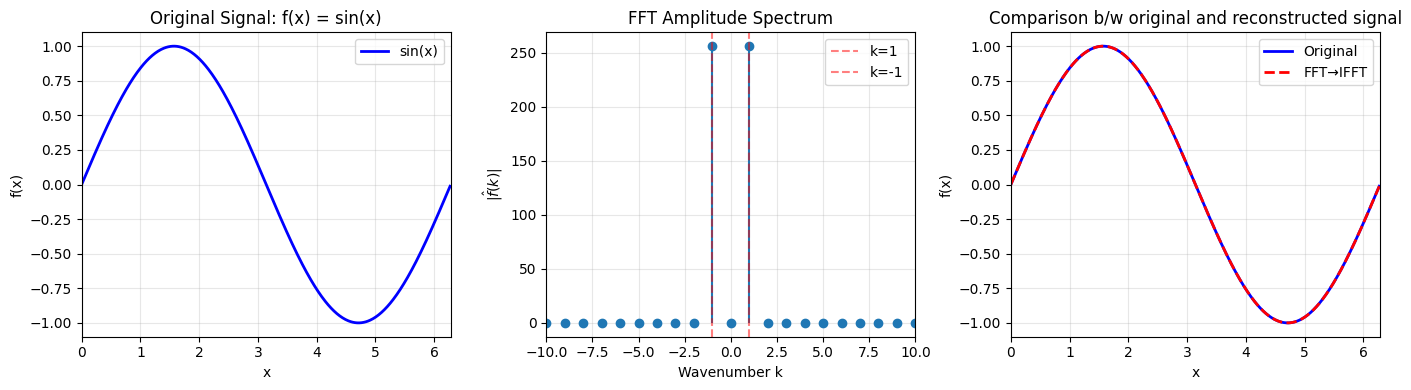

In [9]:
# Validate FFT kernels with a simple sine wave test
from utils import validate_fft_roundtrip

fig, axes, max_error = validate_fft_roundtrip(
    fft_kernel=fft_tiled,
    ifft_kernel=ifft_tiled,
    n_grid=N_GRID,
    tile_m=TILE_M,
    tile_n=TILE_N,
    block_dim=BLOCK_DIM,
)

### Step 3: Tiled transpose kernel

To compute 2-D FFT using 1-D row transforms, we need a transpose operation between passes

$$\text{2-D FFT} = \text{row FFT} \rightarrow \text{transpose} \rightarrow \text{row FFT}.$$

To perform the matrix transpose, we again use Warp's tile-based primitive `wp.tile_transpose()` below in the kernel `def tiled_transpose(...)` that takes in a `x` array and transposes it to give the `y` array.

**TODO**: Same question as above, should we ask them to fill in these tile kernels. Again @Eric for a more accurate description of tile-based transpose...


In [10]:
@wp.kernel
def tiled_transpose(x: wp.array2d(dtype=wp.vec2f), y: wp.array2d(dtype=wp.vec2f)):
    """Transpose a 2-D array using tiled approach with shared memory.

    Args:
        x: Input complex array.
        y: Output complex array storing the transpose of x.
    """
    i, j = wp.tid()
    t = wp.tile_load(
        x,
        shape=(TILE_TRANSPOSE_DIM, TILE_TRANSPOSE_DIM),
        offset=(i * TILE_TRANSPOSE_DIM, j * TILE_TRANSPOSE_DIM),
        storage="shared",
    )
    t_transposed = wp.tile_transpose(t)
    wp.tile_store(
        y, t_transposed, offset=(j * TILE_TRANSPOSE_DIM, i * TILE_TRANSPOSE_DIM)
    )

### Validating transpose kernel

The `tiled_transpose` kernel transposes a 2D matrix by swapping rows and columns: element at position $(i, j)$ moves to $(j, i)$. In `def validate_transpose(...)`, we validate this using an upper triangular matrix, which should become lower triangular after transpose. For example, in case of a $4 \times 4$ upper triangular matrix, transpose operation should result in the following change

$$
\begin{bmatrix} 1 & 1 & 1 & 1 \\ 0 & 1 & 1 & 1 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 0 & 1 \end{bmatrix}
\xrightarrow{\text{transpose}}
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 1 & 1 & 0 & 0 \\ 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 \end{bmatrix}.
$$

Module __main__ 571e89c load on device 'cuda:0' took 63.13 ms  (cached)


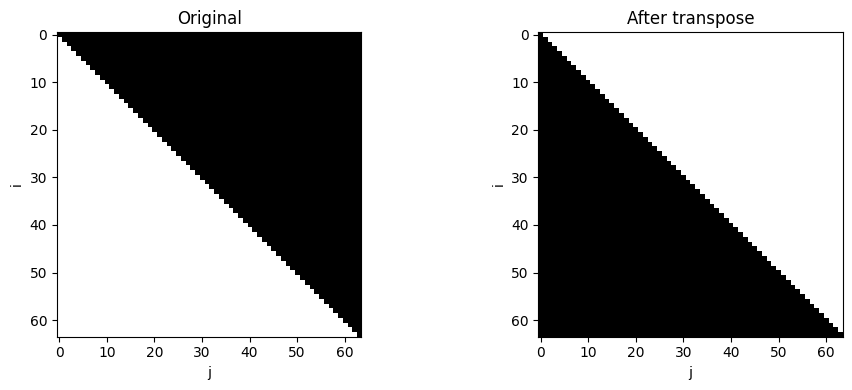

In [11]:
import utils
from utils import validate_transpose

fig, axes = validate_transpose(
    transpose_kernel=tiled_transpose,
    tile_transpose_dim=TILE_TRANSPOSE_DIM,
    n_test=64,
)

### Step 4: Going from $\hat{\omega}$ to $\hat{\psi}$ in the Fourier space

After transforming $\omega$ to Fourier space, we solve equation (3)

$$\hat{\psi}_{m,n} = \frac{\hat{\omega}_{m,n}}{k_x^2 + k_y^2} = \frac{\hat{\omega}_{m,n}}{|k|^2} = \hat{\omega}_{m,n} \cdot |k|^{-2}.$$

We precompute $1/|k|^2$ and multiply it elementwise to the `omega_hat` array to obtain the `psi_hat` array.

**Exercise: Please fill out the `def multiply_k2_inverse(...)` kernel definition.**

In [12]:
@wp.kernel
def multiply_k2_inverse(
    k2i: wp.array2d(dtype=wp.float32),
    omega_hat: wp.array2d(dtype=wp.vec2f),
    psi_hat: wp.array2d(dtype=wp.vec2f),
):
    """Solve Poisson equation in Fourier space: psi_hat = omega_hat / |k|^2.

    Args:
        k2i: Precomputed 1/|k|^2 array (0 at k=0 to handle DC component).
        omega_hat: Fourier transform of vorticity.
        psi_hat: Output Fourier transform of stream function.
    """
    i, j = wp.tid()
    psi_hat[i, j] =  omega_hat[i, j] * k2i[i, j] # MISSING

Now that we have all the kernel calls figured out, we need to put together two Python functions before we start assembling the solver together!

1. `def fft_2d(fft_kernel, input_arr)` - Python function that composes row-wise FFT/IFFT -> transpose → row-wise FFT to perform a full 2-D FFT/IFFT on a input complex (`wp.vec2f`) array.

2. `def solve_poisson(omega, k2i)` - Python function that takes the real-valued vorticity field and pre-computed $|k|^2$ and gives out real values $\psi$.

3. `def step(omega_old, omega_new)` - Python function that performs on Runge-Kutte timestep to go from `omega_old` to `omega_new`.

**Exercise: Until now, you have mostly filled in and worked through Warp kernels and functions. In the next cell, we ask you to call a Warp kernel from inside the Python function `def fft_2d(fft_kernel, input_arr)`. This function is FFT/IFFT agnostic and can be used for both (how?). We ask you to fill two kernel calls, one to `def tiled_transpose(...)` and another to `def fft_kernel(...)`.**

In [13]:
def fft_2d(fft_kernel, input_arr):
    """Perform 2-D FFT or IFFT using row-wise transform + transpose pattern.

    Args:
        fft_kernel: Either def fft_tiled(...) or def ifft_tiled(...) Warp kernel.
        input_arr: Input complex array.
    
    Returns:
        Output complex array with FFT/IFFT results.
    """
    # allocate temporary buffers for intermediate FFT results
    temp_1 = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)
    temp_2 = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)

    # perform rowwise FFT/IFFT
    wp.launch_tiled(
        fft_kernel,
        dim=[N_GRID, 1],
        inputs=[input_arr],
        outputs=[temp_1],
        block_dim=BLOCK_DIM,
    )

    wp.launch_tiled(
        tiled_transpose,
        dim=(N_GRID // TILE_TRANSPOSE_DIM, N_GRID // TILE_TRANSPOSE_DIM),
        inputs= [temp_1], # MISSING 
        outputs= [temp_2], # MISSING 
        block_dim=TILE_TRANSPOSE_DIM * TILE_TRANSPOSE_DIM,
    )

    # perform columnwise FFT/IFFT
    output_arr = wp.empty_like(input_arr)
    wp.launch_tiled(
        fft_kernel,
        dim=[N_GRID, 1],
        inputs= [temp_2], # MISSING 
        outputs=[output_arr],
        block_dim=BLOCK_DIM,
    )
    
    return output_arr

**Exercise: Now, let's fill in the function call to `def fft_2d(...)` in the `def solve_poisson(...)` below.**

In [14]:
def solve_poisson(omega, psi, k2i):
    """Solve the Poisson equation using FFT.
    
    Args:
        omega: Vorticity field (wp.float32 array).
        psi: Stream function solution (wp.float32 array).
        k2i: Precomputed 1/|k|^2 array.
    """
    # allocate all temporary arrays locally
    omega_complex = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)
    temp_1 = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)
    temp_2 = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)

    # convert vorticity from wp.float32 to wp.vec2f
    wp.launch(copy_float_to_vec2, dim=(N_GRID, N_GRID),
              inputs=[omega], outputs=[omega_complex])

    # forward FFT: take omega
    # Remember fft_2d first and second arguments are fft_tiled/ifft_tiled and vorticity field (complex valued, wp.vec2f)
    temp_1 = fft_2d(fft_tiled, omega_complex) # MISSING

    # solve Poisson in Fourier space: psi_hat = omega_hat / |k|^2
    wp.launch(multiply_k2_inverse, dim=(N_GRID, N_GRID),
              inputs=[k2i, temp_1], outputs=[temp_2])

    # inverse FFT: psi_hat -> psi
    # Remember fft_2d first and second arguments are fft_tiled/ifft_tiled and vorticity field (complex valued, wp.vec2f)
    temp_1 = fft_2d(ifft_tiled, temp_2) # MISSING

    # extract real part and normalize
    wp.launch(extract_real_and_scale, dim=(N_GRID, N_GRID),
              inputs=[wp.float32(N_GRID * N_GRID), temp_1],
              outputs=[psi]) # MISSING

### Validating the Poisson solver

We validate `solve_poisson` using an analytical test case. Consider the Poisson equation $\nabla^2 \psi = -\omega$. If we choose $\psi_{\text{analytical}} = \sin(k_x x)\sin(k_y y)$, then

$$\nabla^2 \psi = -k_x^2 \sin(k_x x)\sin(k_y y) - k_y^2 \sin(k_x x)\sin(k_y y) = -(k_x^2 + k_y^2)\sin(k_x x)\sin(k_y y).$$

which means $\omega = (k_x^2 + k_y^2)\sin(k_x x)\sin(k_y y)$.

In the `def validate_poisson_solver(...)`, we set $\omega = (k_x^2 + k_y^2)\sin(k_x x)\sin(k_y y)$ and make a call to `def solve_poisson(...)` to obtain $\psi_{\text{numerical}}$. Thereafter, we compare the obtained $\psi_{\text{numerical}}$ with $\psi_{\text{analytical}}$.

In the cell below, for starters, we have set $k_x = k_y = 1$. Run the cell and see what you get. 

**Exercise: Change the values of $k_x$ and $k_y$ and see how the plots look for different $[k_x, k_y]$ pair.**

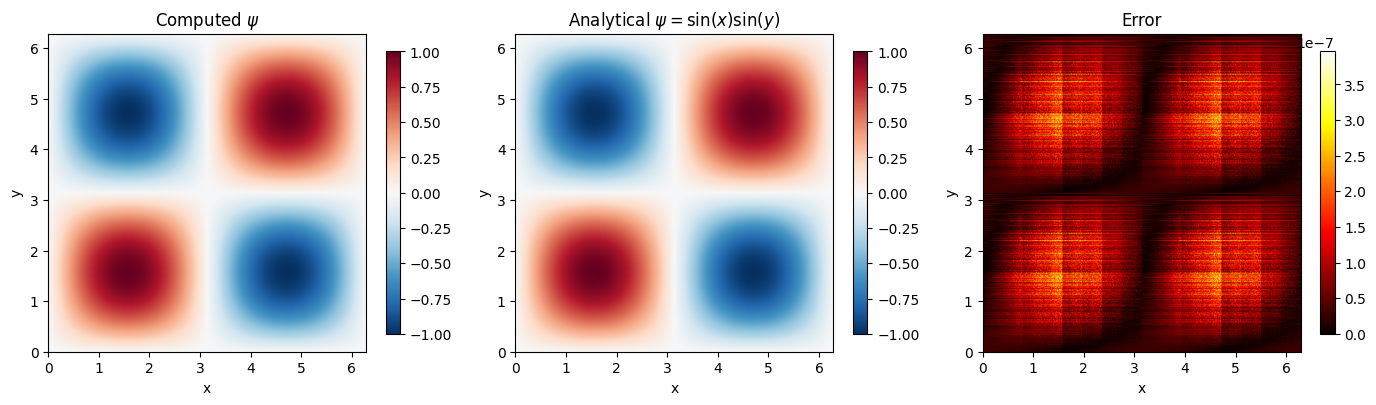

In [19]:
# Validate Poisson solver
from utils import validate_poisson_solver

fig, axes, max_error = validate_poisson_solver(
    solve_poisson_func=solve_poisson,
    n_grid=N_GRID,
    kx=1,
    ky=1,
)

We have already given you the `def step(...)` full definition in the cell below. A single call to `def step(...)` basically advances the whole $\omega$ field on the 2-D grid from $t$ to $t + \Delta t$. 

In [ ]:
def step(omega_0, omega_1, psi, rhs, k2i):
    """Advance simulation by one timestep using SSP-RK3.
    
    Args:
        omega_0: Vorticity at the start of timestep on the 2-D grid.
        omega_1: Vorticity at the end of timestep/RK substep on the 2-D grid.
        psi: Stream function on the 2-D grid.
        rhs: Temporary array for advection + diffusion terms.
        k2i: Precomputed 1/|k|^2 for Poisson solver.
    """
    # loop over 3 RK substeps with coefficients (c0, c1, c2)
    for c0, c1, c2 in RK3_COEFFS:
        rhs.zero_()

        # kernel call to compute the advection and diffusion components
        # then advance the vorticity 1 RK3 substep
        wp.launch(
            viscous_advection_rk3_kernel,
            dim=(N_GRID, N_GRID),
            inputs=[N_GRID, H, RE, DT, c0, c1, c2, omega_0, omega_1, psi, rhs],
        )

        # solve Poisson equation to get psi from omega_1
        solve_poisson(omega_1, psi, k2i)

    # omega_1 now holds omega(t+dt), copy back to omega_0 for next timestep
    wp.copy(omega_0, omega_1)

---
## Assembling the Solver



Now that we have all the building blocks in place, let's put them together to run the simulation. In the cells below, we will:

1. Allocate arrays for vorticity ($\omega$), stream function ($\psi$), RHS terms, and pre-compute $1/|k|^2$.
2. Initialize the vorticity field using the decaying turbulence spectrum mentioned above.
3. Capture the time-stepping loop in a CUDA graph for improved performance.
4. Run the simulation and visualize the results.

### 1. Allocating arrays for the simulation

In [ ]:
# allocate warp arrays for vorticity, stream-function, and RHS of NS equation
omega_0 = wp.zeros((...), dtype=wp.float32) # MISSING
omega_1 = wp.zeros((...), dtype=wp.float32) # MISSING
psi = wp.zeros((...), dtype=wp.float32) # MISSING
rhs = wp.zeros((...), dtype=wp.float32) # MISSING

# precompute 1/k^2 for spectral Poisson solver (avoid division by zero at k=0)
k = np.fft.fftfreq(N_GRID, d=1.0 / N_GRID)
kx, ky = np.meshgrid(k, k)
k2 = kx**2 + ky**2
k2i_np = np.zeros_like(k2)
nonzero = k2 != 0
k2i_np[nonzero] = 1.0 / k2[nonzero]
k2i = wp.array2d(k2i_np.astype(np.float32), dtype=wp.float32)

### I have taken out these temporary arrays for making the tutorial simpler. 
# TODO: Discuss about this
# allocate temporary warp arrays for spectral Poisson solver
# fft_temp_1 = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)
# fft_temp_2 = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)

### 2. Initialize vorticity on the 2-D grid using the spectrum discussed before

In [ ]:
# compute initial vorticity distribution for decaying turbulence
k_mag_np = np.sqrt(k**2 + k[:, np.newaxis] ** 2)
k_mag = wp.array2d(k_mag_np.astype(np.float32), dtype=wp.float32)

rng = np.random.default_rng(42)
zeta_np = 2 * np.pi * rng.random((N_GRID // 2 + 1, N_GRID // 2 + 1))
eta_np = 2 * np.pi * rng.random((N_GRID // 2 + 1, N_GRID // 2 + 1))
zeta = wp.array2d(zeta_np.astype(np.float32), dtype=wp.float32)
eta = wp.array2d(eta_np.astype(np.float32), dtype=wp.float32)
omega_complex = wp.zeros((N_GRID, N_GRID), dtype=wp.vec2f)

# set parameters for energy spectrum
K_P = 12.0
S = 3

wp.launch(
    decaying_turbulence_initializer,
    dim=(N_GRID, N_GRID),
    inputs=[N_GRID, K_P, S, k_mag, zeta, eta],
    outputs=[...], # MISSING
)

# compute IFFT of omega_complex field to get initial vorticity in physical space
# Remember fft_2d first and second arguments are fft_tiled/ifft_tiled and vorticity field (complex valued, wp.vec2f)
fft_result = fft_2d(...) # MISSING

# extract real part to get initial vorticity field (scale=1.0 for normalization)
wp.launch(
    extract_real_and_scale,
    dim=(N_GRID, N_GRID),
    inputs=[1.0, fft_result],
    outputs=[omega_0],
)

# for initial distribution, set both omega_1 and omega_0 to be the same
wp.copy(omega_1, omega_0)

# solve initial Poisson equation to get psi from initial vorticity field
solve_poisson(omega_1, psi, k2i)

### 3. CUDA graph capture

CUDA graphs let you define a sequence of operations (kernel launches, data movement) and their dependencies once, then replay it repeatedly with minimal overhead. Normally, each kernel launch incurs CPU-side setup costs. For short-running kernels launched many times, this overhead dominates. By capturing the entire workflow in a graph, these setup costs are paid once during graph creation, and subsequent launches are nearly free.

In Warp, you can capture a CUDA graph with `wp.ScopedCapture()`. In the code block below, a single call to `step(...)` is captured and will be replayed for as many times as we want to run the simulation.

In [ ]:
# capture first step in a CUDA graph
with wp.ScopedCapture() as capture:
    step(omega_0, omega_1, psi, rhs, k2i)
step_graph = capture.graph

### 4. Running the simulation and saving the results

The boilerplate code below runs the simulation for 2000 timesteps and saves the vorticity field at every 10th timestep. Thereafter, the vorticity fields are plotted and saved as a GIF.

In [ ]:
import time
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os

NUM_FRAMES = 200
STEPS_PER_FRAME = 10

# Colormap setup
cmap = plt.cm.twilight
norm = Normalize(vmin=-15, vmax=15)

frames = []
print(f"Running {NUM_FRAMES} frames ({STEPS_PER_FRAME} steps each)...")

start_time = time.perf_counter()
for frame in range(NUM_FRAMES):
    # Advance simulation
    for _ in range(STEPS_PER_FRAME):
        wp.capture_launch(step_graph)

    # Capture frame
    vorticity = omega_1.numpy().T  # Transpose for correct orientation
    colored = cmap(norm(vorticity))
    rgb = (colored[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb)

    if (frame + 1) % 50 == 0:
        print(f"  Frame {frame + 1}/{NUM_FRAMES}")

elapsed = time.perf_counter() - start_time
total_steps = NUM_FRAMES * STEPS_PER_FRAME
print(f"Completed {total_steps} steps in {elapsed:.2f}s ({total_steps/elapsed:.0f} steps/s)")

In [ ]:
import IPython.display

# Create output directory
os.makedirs("./images/chapter-12.2", exist_ok=True)
output_file = f"./images/chapter-12.2/turbulence_{N_GRID}x{N_GRID}_Re{int(RE)}.gif"

# Save as GIF
pil_images = [Image.fromarray(frame) for frame in frames]
pil_images[0].save(
    output_file,
    save_all=True,
    append_images=pil_images[1:],
    duration=50,
    loop=0,
)

print(f"Saved: {output_file}")
IPython.display.Image(output_file)

---
## Validation

**TODO**

---
## Conclusion

**TODO**

---
## References

**TODO**

---
## Appendix A: Phase symmetry for real-valued physical fields

Following San and Staples 2012, we decompose the phase as $\zeta(\mathbf{k}) = \xi(\mathbf{k}) + \eta(\mathbf{k})$, where $\xi$ and $\eta$ are independently chosen random values in $[0, 2\pi]$ in the first quadrant ($k_x \geq 0$, $k_y \geq 0$).

$\xi(\mathbf{k})$ and $\eta(\mathbf{k})$ must follow these relations in other quadrants

$$\xi(-k_x, k_y) = -\xi(k_x, k_y),$$
$$\xi(-k_x, -k_y) = -\xi(k_x, k_y),$$
$$\xi(k_x, -k_y) = \xi(k_x, k_y),$$

$$\eta(-k_x, k_y) = \eta(k_x, k_y),$$
$$\eta(-k_x, -k_y) = -\eta(k_x, k_y),$$
$$\eta(k_x, -k_y) = -\eta(k_x, k_y).$$